In [1]:
%cd ..

/home/ubuntu/dev/pepper


In [2]:
# builtin
from collections import Counter, defaultdict
from copy import deepcopy
import os.path as osp
import re
from shutil import copy2 as copy

# third-party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch

# mm
import mmcv
from mmcv import Config
from mmcv.utils import build_from_cfg

/home/ubuntu/.pyenv/versions/3.8.8/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
from pepper.datasets import DATASETS

In [4]:
cfg = Config.fromfile("tests/configs/_base_/datasets/mini_market1501.py")
print(cfg.pretty_text)

img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile', to_float32=True),
    dict(
        type='ProbRandomResizedCrop',
        size=(256, 128),
        scale=(0.5, 0.99),
        crop_prob=0.5),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='RandomErasing',
        erase_prob=0.5,
        min_area_ratio=0.02,
        max_area_ratio=0.4),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Collect', keys=['img', 'gt_label']),
    dict(type='FormatBundle')
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', size=(256, 128), interpolation='bilinear'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='ImageToTensor', keys=['i

In [5]:
dataset = build_from_cfg(cfg.data.train, DATASETS)

In [6]:
print(dataset.ann_file)
print(dataset.data_infos)
print(len(dataset.data_infos))
print(len(dataset))
print(dataset.NUM_PIDS)
print(dataset.NUM_CAMIDS)

tests/data/mini_market1501/gtPepper/train.json
[{'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'img_info': {'filename': '0011_c6s4_002352_01.jpg', 'pid': 6, 'camid': 5, 'split': 'train', 'debug_index': 0}, 'gt_label': array(6)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'img_info': {'filename': '0035_c4s1_003426_01.jpg', 'pid': 2, 'camid': 3, 'split': 'train', 'debug_index': 1}, 'gt_label': array(2)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'img_info': {'filename': '0007_c3s3_077344_04.jpg', 'pid': 4, 'camid': 2, 'split': 'train', 'debug_index': 2}, 'gt_label': array(4)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'img_info': {'filename': '0043_c6s1_004426_01.jpg', 'pid': 7, 'camid': 5, 'split': 'train', 'debug_index': 3}, 'gt_label': array(7)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'img_info': {'filename': '0007_c2s3_071002_01.jpg', 'pid': 4, 'camid': 1, 'split': 'train', 'deb

In [15]:
sample = dataset[1]

In [16]:
print(sample.keys())
print(type(sample['img']), type(sample['gt_label']))
print(sample['img_metas'])

dict_keys(['img', 'gt_label', 'img_metas'])
<class 'mmcv.parallel.data_container.DataContainer'> <class 'mmcv.parallel.data_container.DataContainer'>
DataContainer({'filename': 'tests/data/mini_market1501/bounding_box_train/0035_c4s1_003426_01.jpg', 'ori_filename': '0035_c4s1_003426_01.jpg', 'ori_shape': (128, 64, 3), 'img_shape': (128, 64, 3), 'flip': True, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}, 'pid': 2, 'camid': 3, 'split': 'train', 'debug_index': 1})


In [17]:
class UnNormalize(object):
    def __init__(self, mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # WARN: this is inplace!!!
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [18]:
mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]

unnorm = UnNormalize(mean=mean, std=std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min/max tensor(-1.9199) tensor(2.6400)


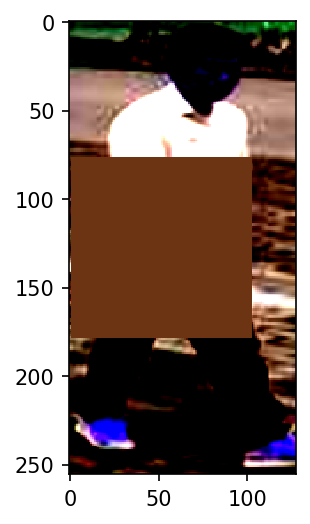

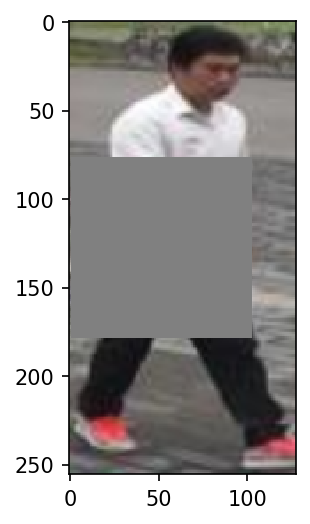

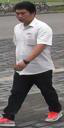

In [19]:
img = sample['img'].data

print('min/max', img.min(), img.max())

unnorm_img = unnorm(deepcopy(img))
img = img.numpy().transpose((1, 2, 0))[:, :, [2, 1, 0]]
unnorm_img = unnorm_img.numpy().transpose((1, 2, 0)).astype(np.uint8)

plt.imshow(img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(unnorm_img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

pil_img = Image.open(sample['img_metas'].data['filename'])
pil_img.show()

In [44]:
print(sample['gt_label'])

DataContainer(tensor(6))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


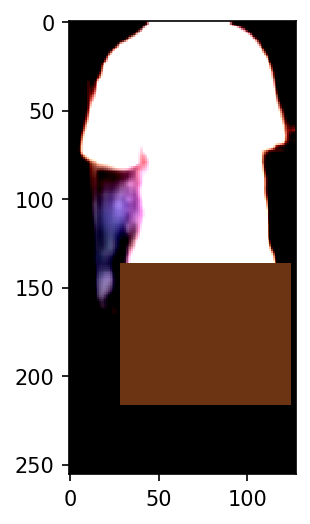

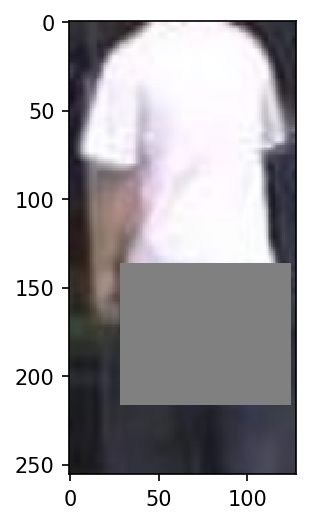

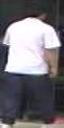

In [15]:
sample = dataset[8]

img = sample['img'].data
unnorm_img = unnorm(deepcopy(img))
img = img.numpy().transpose((1, 2, 0))[:, :, [2, 1, 0]]
unnorm_img = unnorm_img.numpy().transpose((1, 2, 0)).astype(np.uint8)

plt.imshow(img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(unnorm_img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

pil_img = Image.open(sample['img_metas'].data['filename'])
pil_img.show()